# Visualize Simulated Boycott Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts



In [365]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt

num_users = {
    'ml-20m': 138493,
    'ml-1m': 6040
}
num_ratings = {
    'ml-20m': 20000263,
    'ml-1m': 1000209
}
for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, ratio)

ml-20m 144.4135299257002
ml-1m 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [274]:
df_1m = pd.read_csv('ml-1m_collected/all_results.csv', dtype={'indices': str})
df_1m = df_1m[df_1m.ratingfrac.notna()]

In [275]:
df_20m = pd.read_csv('ml-20m_collected/all_results.csv', dtype={'indices': str})
df_20m = df_20m[df_20m.ratingfrac.notna()]

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

In [306]:
for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    # Whoops! Assign doesn't work in a for loop.
#     df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
#     df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
#     df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]

    # drop columns we're not going to use.
    drops = [
        #'tail',
        # 'vanilla',
    ]
    for column in df.columns.values:
        for drop in drops:
            if drop in column:
                df = df.drop(column, axis=1)

# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [354]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    #'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    #'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'SVD', 
    #'GlobalMean', 'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [355]:
dataset_to_algo_to_metric_to_altalgo = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo_to_metric_to_altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo_to_metric_to_altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo_to_metric_to_altalgo[main_algo_name][metric][st_algo_name] = 0
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo_to_metric_to_altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo_to_metric_to_altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo_to_metric_to_altalgo
pprint(dataset_to_algo_to_metric_to_altalgo)

File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
{'ml-1m': defaultdict(<function <lambda> at 0x000001C1D3F15E18>,
                      {'SVD': defaultdict(<class 'dict'>,
                                          {'ndcg10': {'KNNBaseline_item_msd': -0.21579272303199185,
                                                      'KNNBasic_item_msd': -0.783459813821296,
                                                      'KNNBasic_user_msd': -1.774069901999796,
                                                      'MovieMean': -2.527446665665193,
                                                      'SVD': 0.0},
                                           'rmse': {'KNNBaseline_item_msd': 1.326125568048003,
                                                    'KNNBasic_item_msd': 4.626236780474338,
                                                    'KNNBasic_user_msd': 5.627334338473019,
                                                    'MovieMean': 12.

## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts.

In [356]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())


===Heterogenous 20M Boycotts===

124644 user sample    50
27699 user sample     50
55397 user sample     50
110794 user sample    50
83096 user sample     50
96945 user sample     50
6925 user sample      50
137108 user sample    50
1385 user sample      50
69 user sample        50
138 user sample       50
692 user sample       50
69246 user sample     50
14 user sample        50
13849 user sample     50
41548 user sample     50
Name: name, dtype: int64

===Heterogenous Boycotts===

4832 user sample    250
4228 user sample    250
30 user sample      250
3020 user sample    250
3624 user sample    250
6 user sample       250
302 user sample     250
1208 user sample    250
3 user sample       250
5980 user sample    250
60 user sample      250
1 user sample       250
2416 user sample    250
604 user sample     250
5436 user sample    250
1812 user sample    250
Name: name, dtype: int64

===Homogenous Boycotts===

male users excluded                              60
female users excluded 

## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots too confusing.

In [357]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
#     .replace('US_', '')
#     .replace('state', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Data Manipulating Helpers
In the following two cells, we define two functions (`select_cols` and `fill_in_longform`) that will help with general purpose manipulating of our result data.

In [358]:
def select_cols(cols, metrics, groups, percents):
    """
    take a list of cols and filter based on metrics/groups/percents
    
    The returned columns must match all the metrics and groups passed
    if percents is True, return columns with "percent" in the name
    if percents is False return only columns without "percent" in the name
    
    returns a list of cols
    """
    increase_cols = [
        x for x in cols if 'increase' in x and (any(metric == x.split('_')[-2] for metric in metrics))
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [359]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [360]:
palette={'all': 'b', 'non-boycott': 'g'}
TITLE = 'Effect of Boycott Size on Recommender Performance'
YLABEL = 'nDCG@10 personalization factor'

In [373]:
def p_b_curve(
        df, dataset, metrics, groups,
        percents=False, normalize=True,
        reg_plot=False, hue='group', row='metric',
        save=False, show_interp=False,
    ):
    """
    Plots a performance vs. boycott size (P v B) curve
    
    Args:
        df - the dataframe to use for plotting the pb curve
        metrics - which metrics to plot the curve for.
        groups - which groups to include.
          for each metric, 
        percents - show the Y-axis in percent change or raw change. Set this True for percent change.
        normalize - should we normalize the y-axis relative to MovieMean (no personalization)
        reg_plot - ?
        hue - which facet to use to determine hue. default is group
          (each group will appear as a separate (distinctly colored) trajectory on each plot)
        row - which facet to use to split plots into different rows. default is metric.
        save - should we save a PNG file?
        show_interp - include the interpolated function on this plot?
        
    Returns:
        ?
    """
    algo_to_metric_to_altalgo=dataset_to_algo_to_metric_to_altalgo[dataset]
    
    algo_names = list(set(df.algo_name))
    df = df.copy()
    algo_to_metric_to_group_to = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    if normalize:
        for metric in metrics:
            for algo_name in algo_names:
                movie_val = abs(algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'])
                for increase_col in increase_cols:
                    if increase_col.split('_')[-2] == metric:
                        df.loc[df.algo_name == algo_name, increase_col] /= movie_val
    
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)

    grid = sns.lmplot(
        x="num_users_boycotting", y="value", hue=hue, data=longform,
        sharey='row', sharex='col',
        size=4, 
        row=row, col='algo_name',
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
        palette=palette,
        legend_out=True,
    )
    

    algo_to_size_to_decreases = defaultdict(lambda: defaultdict(list))
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            for group in groups:
                key = 'increase_{}_{}'.format(metric, group)
                if percents:
                    key = 'percent_' + key
                x = filt.num_users_boycotting
                user_nums = sorted(list(set(filt.num_users_boycotting)))
                nrm_rounded = sorted(list(set(filt.nrm_rounded)))
                y = filt[key]

                num_to_mean = OrderedDict()
                rounded_num_to_mean = OrderedDict()
                for num_users_boycotting in user_nums:
                    filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                    num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
                    rounded_num_to_mean[round(num_users_boycotting, 2)] = np.mean(filt_by_name[key])
                nrm_rounded_to_mean = OrderedDict()
                for num in nrm_rounded:
                    filt_by_nrm = filt[filt.nrm_rounded == num]
                    nrm_rounded_to_mean[num] = np.mean(filt_by_nrm[key])

                if group == 'non-boycott':
                    for num in [
                        0.1, 0.2, 0.3,
                    ]:
                        
                        val_nb = rounded_num_to_mean.get(num)
                        if val_nb is None:
                            continue
                        val_all = np.mean(filt[filt.num_users_boycotting == num][key.replace('non-boycott', 'all')])
                        print(
                            'Algo:{}  |  Metric:{}  |  #users:{}'.format(
                                algo_name, metric, num, 
                            )
                        )
                        print('NB Val:{}  |  ALL val:{}'.format(
                            val_nb,
                            val_all
                        ))
                        if percents is False:
                            ratio_nb = val_nb / algo_to_metric_to_altalgo[algo_name][metric]['MovieMean']
                            ratio_all = val_all / algo_to_metric_to_altalgo[algo_name][metric]['MovieMean']

                            print('ratio_nb: {}  |  ratio_all:{}'.format(
                                ratio_nb,
                                ratio_all,
                            ))
                        algo_to_size_to_decreases[algo_name][num].append(val_nb)
                meany = np.array(list(num_to_mean.values()))
                meany_ratings = np.array(list(nrm_rounded_to_mean.values()))

                algo_to_metric_to_group_to[algo_name][metric][group]['x'] = user_nums
                algo_to_metric_to_group_to[algo_name][metric][group]['y'] = meany

                smoothf_ratings = interp1d(nrm_rounded, meany_ratings, kind='quadratic', bounds_error=False, fill_value='extrapolate')
                algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'] = smoothf_ratings
                algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] = max(user_nums)
                algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings'] = np.linspace(
                    min(filt.num_ratings_missing), max(filt.num_ratings_missing), num=1000)

                
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        
        lines_caption = ""
        
        lines = {}
        lines['KNNBaseline_item_msd'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBaseline_item_msd'],
            'color': 'y',
            'name': 'Item KNN + Baselines: 2010',
            'linestyle': ':',
        }
        lines['MovieMean'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'],
            'color': '0.3',
            'name': 'MovieMean',
            'linestyle': '-'
        }
        lines['Zero'] = {
            'value': 0,
            'color': '0.3',
            'name': 'Zero',
            'linestyle': '-'
        }
        
        lines['KNNBasic_item_msd'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBasic_item_msd'],
            'color': 'r',
            'name': 'Item KNN (1999)',
            'linestyle': ':'
        }
        
        if dataset == 'ml-1m':   
            lines['KNNBasic_user_msd'] = {
                'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBasic_user_msd'],
                'color': 'c',
                'name': 'User KNN (1994)',
                'linestyle': ':'
            }
        elif dataset == 'ml-20m':
            lines['1M_SVD'] = {
                'value': algo_to_metric_to_altalgo[algo_name][metric]['1M_SVD'],
                'color': 'c',
                'name': 'ml-1m SVD',
                'linestyle': ':'
            }
        
        if normalize:
            norm_val = abs(algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'])
            for key in lines.keys():
                lines[key]['value'] /= norm_val
        
        ax = grid.axes[i_row, i_col]
        
        if normalize and metric == 'ndcg10':
            if dataset == 'ml-1m':
                ax.set(ylim=(-1.6, 0.1))
            elif dataset == 'ml-20m':
                ax.set(ylim=(-1.2, 0.1))
    
        linestyle = '-' if group  != 'all' else '--'

        ax.plot(
            algo_to_metric_to_group_to[algo_name][metric][group]['x'],
            algo_to_metric_to_group_to[algo_name][metric][group]['y'],
            linestyle=linestyle, color=grid._colors[i_hue]
        )
        if show_interp:
            xnew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings']
            ynew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'](xnew_ratings)
            ax.plot(
                xnew_ratings * algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] / num_ratings[dataset],
                ynew_ratings, '-')

        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
        if percents:
            
            for line in lines.values():
                ax.axhline(line['value'], color=line['color'], linestyle=line['linestyle'])
                #ax.text(0.7, line['value'] + 0.05, line['name'])
                lines_caption += "{} colored line (value of {}) shows comparison with {}\n".format(
                    line['color'], line['value'], line['name']
                )
        print(lines_caption)

    plt.subplots_adjust(hspace=0.2)
    algo_to_size_to_mean_dec = defaultdict(dict)
    for algo_name, size2dec in algo_to_size_to_decreases.items():
        for size, decs in size2dec.items():
            algo_to_size_to_mean_dec[algo_name][size] = np.mean(decs)
    print('=====\nSize to Mean Decrease')
    pprint(algo_to_size_to_mean_dec)
                   
    grid.set_xlabels('Fraction of users boycotting')
    grid.set_ylabels(YLABEL)
    if save:
        new_labels = ['All\nUsers', 'Not\nBoycotting\nUsers',]
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        grid._legend.set_title('')
        grid.set_titles(TITLE)
        plt.savefig('sample.svg', bbox_inches='tight', dpi=300)
    return algo_to_metric_to_group_to

Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.06754775360839378  |  ALL val:-0.17066137274875315
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.14355844612009977  |  ALL val:-0.3353765179702833
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.2305288131116384  |  ALL val:-0.4933845828779054
y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)
c colored line (value of -0.7019217956604764) shows comparison with User KNN (1994)

y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)

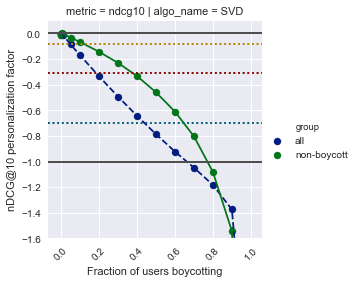

In [374]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10', ],
    groups=['non-boycott', 'all', ],
    save=False,     
)
plt.show()

Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.007788517547258645  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.016260668657253688  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.028071160999143897  |  ALL val:nan
y colored line (value of -0.4507662672118879) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.3963203167320593) shows comparison with Item KNN (1999)
c colored line (value of -0.4242650747079455) shows comparison with ml-1m SVD

y colored line (value of -0.4507662672118879) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.3963203167320593) shows comparison with Item KNN (1999)
c colored line (value of -0.4242650747079455) shows co

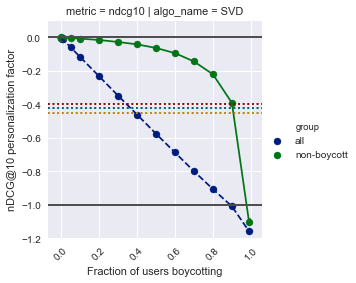

In [377]:
twenty_algo_to_metric_to_group_to = p_b_curve(
    samples_df_20m, 'ml-20m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10'],
    groups=['non-boycott', 'all', ],
    save=False,     
)
plt.show()

Algo:SVD  |  Metric:rmse  |  #users:0.1
NB Val:0.02472945762459065  |  NB Ratio:0.0020483788354189914
all Val:0.13097278592843878  |  all Ratio:0.010848676375534428
Algo:SVD  |  Metric:rmse  |  #users:0.3
NB Val:0.07844807863338582  |  NB Ratio:0.00649797445586202
all Val:0.3821830060587016  |  all Ratio:0.031656803507449
Algo:SVD  |  Metric:rmse  |  #users:0.9
NB Val:0.5324001719149722  |  NB Ratio:0.0440995213352203
all Val:1.2259212079600144  |  all Ratio:0.10154493051960516
Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.06754775360839378  |  NB Ratio:0.026725689022844737
all Val:-0.17066137274875315  |  all Ratio:0.0675232340476855
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.2305288131116384  |  NB Ratio:0.09121015934512945
all Val:-0.4933845828779054  |  all Ratio:0.19521068024121987
Algo:SVD  |  Metric:ndcg10  |  #users:0.9
NB Val:-1.5423016073244624  |  NB Ratio:0.6102212277221476
all Val:-1.3739130434566418  |  all Ratio:0.54359724465048
=====
Size to Mean Decrease

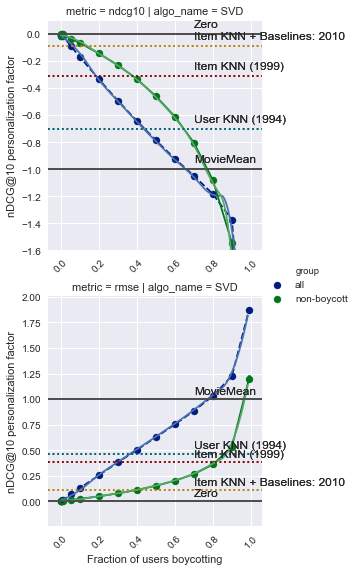

In [343]:
algo_to_metric_to_group_to = p_b_curve(
    samples_df_1m, 'ml-1m',
    metrics=metrics,
    percents=True, normalize=True, show_interp=True,
    groups=['non-boycott', 'all', ],
)
plt.show()

## Find intersection of the non-boycott curve with horizontal lines

In [376]:
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['MovieMean']
for group in ['all', 'non-boycott']:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], num_ratings['ml-1m'] / 10000):
        y = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](x)
        #print(x, y)
        if not found_item:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBaseline_item_msd']/movie_val:
                print(group + ' found item:')
                print(x/NUM_RATINGS)
                found_item = True
        if not found_user:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_user_msd'] / movie_val:
                print(group + ' found user')
                print(x/NUM_RATINGS)
                found_user = True
        if not found_itembasic:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_item_msd'] / movie_val:
                print(group + ' found knnbasicitem')
                print(x/NUM_RATINGS)
                found_itembasic = True

all found item:
0.0626868984382264
all found knnbasicitem
0.18626107143606987
all found user
0.44050793384182707
non-boycott found item:
0.13637149835684342
non-boycott found knnbasicitem
0.37962065928221
non-boycott found user
0.6526635933089984


In [382]:
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-20m']['SVD']['ndcg10']['MovieMean']
d = {}
d[19] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.19 * num_ratings['ml-20m']) * 100
d[44] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.44 * num_ratings['ml-20m']) * 100
print(d)

{19: -1.6981414058489113, 44: -3.9055499446539965}


In [217]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [218]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [219]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [220]:
NORMALIZE = True
normed_org_df = org_df.copy()
for metric in metrics:
    for algo_name in algo_names:
        movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        for group in ['non-boycott', 'like-boycott']:
            col = 'percent_increase_{}_{}'.format(metric, group)
            if NORMALIZE:
                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = 'percent_increase_{}_expected'.format(metric)
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

In [221]:
def plot2(
        df, metrics, groups,
        percents=False, kind='bar', size=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    TODO add a docstring
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
        tmp = df[df.name == name].num_ratings_missing.mean()
        print('name', name)
        print('mean number of ratings missing', tmp)
        print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
#     for metric in metrics:
#         for col in increase_cols:
#             if metric in col and 'expected' in col:
#                 expec = col
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(list)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = 1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
                elif 'like-boycott' in col:
                    lb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                lb_arr = np.array(masked[masked.increase_type == lb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                lb_mean = np.nanmean(lb_arr)
                
                ratio = nb_mean / expec_mean
                diff = nb_mean - expec_mean
                lb_diff = lb_mean - nb_mean
                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue
                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                name_to_ratios[name].append(ratio)
                diffs['nb'].append(diff)
                diffs['lb'].append(lb_diff)
                name_to_counts[name]['total_sig'] += 1
                if diff >= 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                print(lb)
                print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']
#         print(name)
#         print('{} sig, {} less, and {} more out of {} total'.format(
#             counts['total_sig'], counts['total_less'],
#             counts['total_more'], counts['total'])
#         )
#         print('Mean:')
    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Users Similar\n to Boycotting\n Users', 'Not Boycotting\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(YLABEL)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), diffs


In [222]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [223]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']
state_boycotts = org_df[org_df['type'] == 'state']

# removing these from contention
# genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']

In [224]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c'}

def plot_all_three_scenarios(df, size=6):
    if False:
        all_df = all_users_all_ratings(df)
        if not all_df.empty:
            grid, (total, total_sig, total_less, total_more, total_lbless) = plot2(
                all_users_all_ratings(df),
                metrics=metrics,
                percents=True,
                groups=['all', 'non-boycott', 'expected'],
                size=size,
                palette=palette
            )
            grid.fig.suptitle('All Users, All Ratings')
            print('total1', total)
    else:
        total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), ntd = plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            size=size,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
        
#     half_ratings_df = half_ratings(df)
#     if not half_ratings_df.empty:
#         plot2(
#             half_ratings_df,
#             metrics=metrics,
#             percents=True,
#             groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
#             size=size,
#         ).fig.suptitle('Half Ratings')
#     plt.show()
    
    return (total, total_sig, total_less, total_more, total_lbless), ntd

In [225]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
lbdiffs = []
diffs = []

# Make plots for paper here.

len of df (number of experiments included) 200
name fans of film-noir
mean number of ratings missing 62451.2
-0.03275427319282685
name female users
mean number of ratings missing 123511.54
-0.07448639002478806
name male users
mean number of ratings missing 376779.58
-0.306908762503413
name power users
mean number of ratings missing 190493.3
-0.13507052541973943
ndcg10 SVD fans of film-noir, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.5763531756770433, pval: 3.127638858905848e-05
percent_increase_ndcg10_like-boycott
lb info -0.18254269867575848 -0.23420138122254908 -0.051658682546790596
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.8190386156915364, pval: 0.0011278106612399785
percent_increase_ndcg10_like-boycott
lb info -0.07584222634311277 -0.13686491839117532 -0.06102269204806254
ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.103752761333

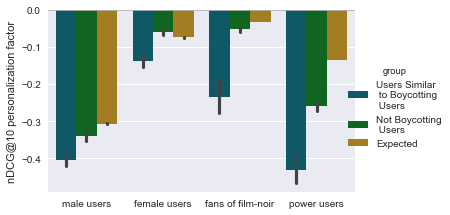

In [226]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), ntd = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['ndcg10'],
    percents=True,
    groups=['non-boycott', 'like-boycott', 'expected'],
    size=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=True,
    palette=palette,
    aspect=1.5
)

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df2[(df2.name.str.contains('Film-Noir')) & (df2.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h2.svg', save=True,
#     palette=palette
# )

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h3.svg', save=True,
#     palette=palette
# )

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 100
name female users
mean number of ratings missing 123511.54
-0.07448639002478806
name male users
mean number of ratings missing 376779.58
-0.306908762503413
rmse SVD female users, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -0.7924713610352061, pval: 5.050955975629304e-55
percent_increase_rmse_like-boycott
lb info 0.02114736552269237 0.042800725555350375 0.021653360032658005
rmse SVD male users, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -1.090665780852551, pval: 3.4497250155333003e-77
percent_increase_rmse_like-boycott
lb info 0.017843204166975574 0.1307526942239034 0.11290949005692782
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.8190386156915364, pval: 0.0011278106612399785
percent_increase_ndcg10_like-boycott
lb info -0.07584222634311277 -0.13686491839117532 -0.06102269204806254
ndcg10 SVD male users, percent_increase_ndc

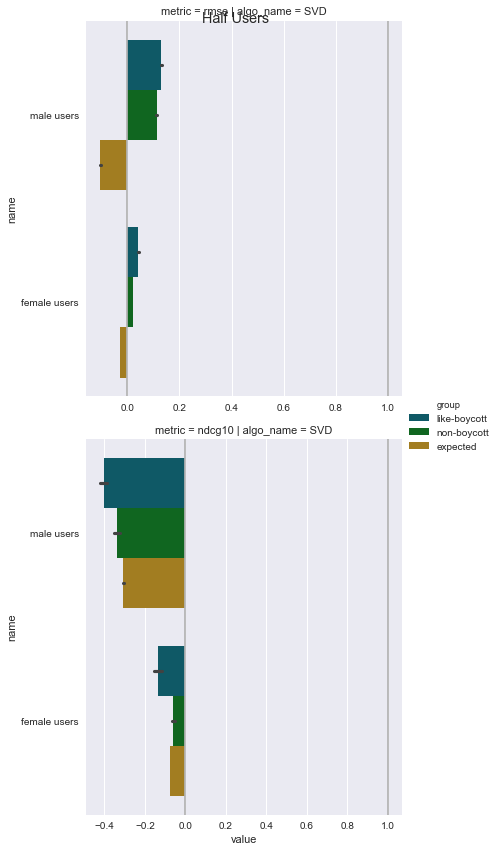

In [229]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']
print(diffs)
plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df (number of experiments included) 100
name bottom 10% contributors
mean number of ratings missing 7203.8
-0.009522238405874552
name power users
mean number of ratings missing 190493.3
-0.13507052541973943
rmse SVD bottom 10% contributors, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -0.350644515121868, pval: 2.8986606142052705e-14
percent_increase_rmse_like-boycott
lb info 0.03709913979993391 0.039033819692498556 0.0019346798925646462
rmse SVD power users, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -1.8928021209406578, pval: 2.4384528315978702e-67
percent_increase_rmse_like-boycott
lb info 0.02582098747908855 0.11521803558504057 0.08939704810595202
ndcg10 SVD bottom 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.34807582946499954, pval: 0.005228589684450362
percent_increase_ndcg10_like-boycott
lb info -1.165898456682662 -1.1625839952011454 0.0033144614815165912
ndcg10 S

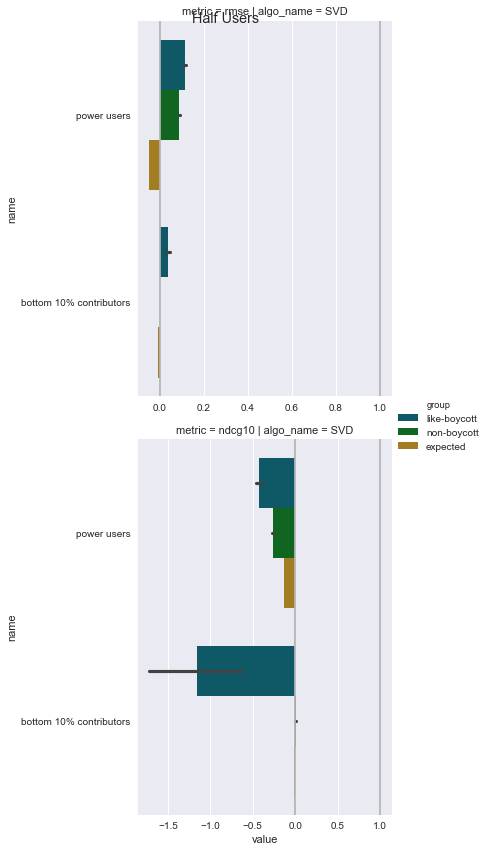

In [230]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']


plt.show()

len of df (number of experiments included) 350
name 25-34
mean number of ratings missing 198083.06
-0.14185472109548397
name 56+
mean number of ratings missing 19358.08
-0.013449096898182182
name under 18
mean number of ratings missing 13690.38
-0.011534835512748715
name 50-55
mean number of ratings missing 36044.12
-0.019928060213786628
name 45-49
mean number of ratings missing 42237.56
-0.022653249723358672
name 35-44
mean number of ratings missing 99157.22
-0.055820221961350155
name 18-24
mean number of ratings missing 91599.78
-0.05057312283053206
rmse SVD 25-34, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -1.0720045451973486, pval: 6.372962456916914e-70
percent_increase_rmse_like-boycott
lb info 0.018326610538816214 0.07133864530755836 0.053012034768742146
rmse SVD 56+, percent_increase_rmse_expected, percent_increase_rmse_non-boycott
Ratio: -0.5356130389619701, pval: 5.830133562964462e-23
percent_increase_rmse_like-boycott
lb info 0.019602181968689205

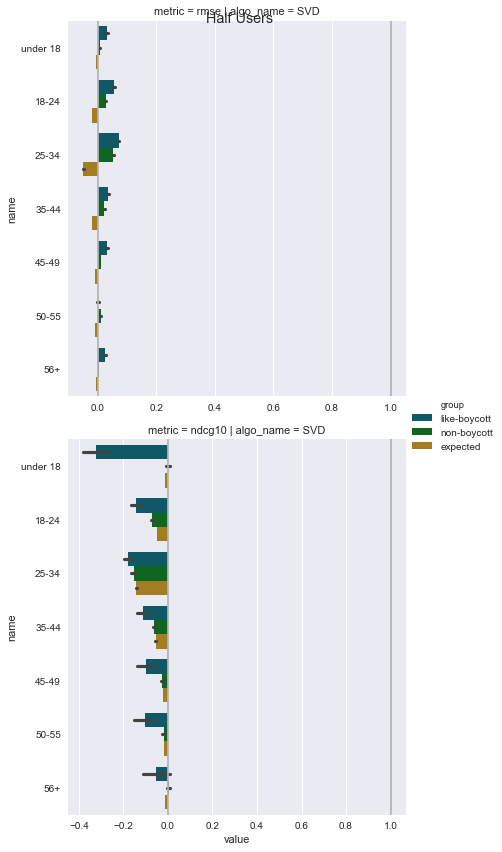

In [231]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']
print(diffs)


plt.show()


len of df (number of experiments included) 1050
name k-12 student
mean number of ratings missing 11535.26
-0.01084506035956718
name programmer
mean number of ratings missing 29008.7
-0.017042802650470642
name lawyer
mean number of ratings missing 10196.7
-0.010427208827199722
name clerical/admin
mean number of ratings missing 15823.08
-0.012238108980529856
name retired
mean number of ratings missing 6870.72
-0.009424028747092908
name self-employed
mean number of ratings missing 23290.52
-0.014862624986925026
name technician/engineer
mean number of ratings missing 36241.4
-0.02001219148722595
name tradesman/craftsman
mean number of ratings missing 6110.76
-0.009201830178689807
name artist
mean number of ratings missing 25329.26
-0.015622978772655302
name other
mean number of ratings missing 65251.36
-0.034299241054837504
name unemployed
mean number of ratings missing 7359.78
-0.009568402048394934
name writer
mean number of ratings missing 30108.58
-0.01747910908397002
name college/grad 

lb info -0.00911094732622441 -0.02207305300275681 -0.012962105676532401
ndcg10 SVD technician/engineer, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0723666975543225, pval: 0.724439145683498
percent_increase_ndcg10_like-boycott
lb info -0.07587642361101839 -0.09734881094809676 -0.021472387337078378
ndcg10 SVD tradesman/craftsman, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.19526414820974602, pval: 0.0019175307985113607
percent_increase_ndcg10_like-boycott
lb info 0.1315197912627244 0.1333169754305048 0.001797184167780399
ndcg10 SVD artist, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6699649302324154, pval: 0.2156844054992115
percent_increase_ndcg10_like-boycott
lb info 0.003849788854826925 -0.006621197798673837 -0.010470986653500762
ndcg10 SVD other, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.045562491478778, pval: 0.6466546540061002
percent_incre

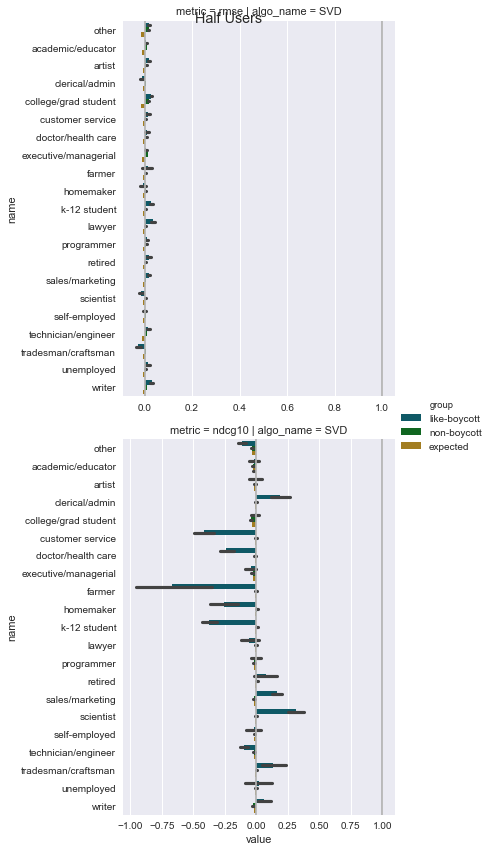

In [237]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']

plt.show()

len of df (number of experiments included) 900
name fans of thriller
mean number of ratings missing 81594.02
-0.04402346188002808
name fans of documentary
mean number of ratings missing 21935.28
-0.014367583318173376
name fans of action
mean number of ratings missing 62366.34
-0.03270800580062659
name fans of adventure
mean number of ratings missing 50984.28
-0.02679734846093064
name fans of crime
mean number of ratings missing 88889.1
-0.04875403501147191
name fans of mystery
mean number of ratings missing 53123.44
-0.027863505002028548
name fans of fantasy
mean number of ratings missing 22704.66
-0.014647603167603168
name fans of horror
mean number of ratings missing 24026.48
-0.015134935691445101
name fans of musical
mean number of ratings missing 60274.1
-0.03157757209503026
name fans of romance
mean number of ratings missing 74698.48
-0.03977319799343347
name fans of western
mean number of ratings missing 26247.58
-0.015971608034535945
name fans of war
mean number of ratings missi

total2 36 36


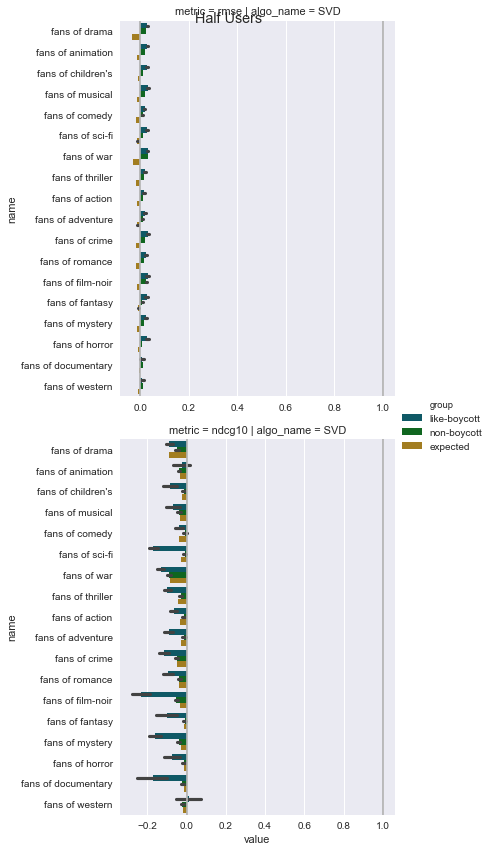

In [233]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs.append(ntd['lb'])
diffs.append(ntd['nb'])

plt.show()

In [235]:
running_totals

{'total': 104,
 'total_lbless': 50,
 'total_less': 80,
 'total_more': 24,
 'total_sig': 104}

In [243]:
print(lbdiffs)
print(diffs)

[0.02114736552269237, 0.017843204166975574, -0.07584222634311277, -0.06495540583386639, 0.02114736552269237, 0.017843204166975574, -0.07584222634311277, -0.06495540583386639, 0.03709913979993391, 0.02582098747908855, -1.165898456682662, -0.17160899698727078, 0.018326610538816214, 0.019602181968689205, 0.023450228567282332, -0.009596665288711026, 0.02039143144385172, 0.013257148121160613, 0.027814882964055578, -0.024862169783425536, -0.056760111460816325, -0.3238456659474422, -0.08478266186702534, -0.07340881502334753, -0.05291675983953624, -0.07422645573381648, 0.023444208920187577, 0.0025347095324398, 0.03277218706462173, -0.01811743858140226, 0.015395005199962397, -0.00794429135504057, 0.00653836697899114, -0.03288265210070527, 0.010348999682668964, 0.0007338801606535592, 0.008224407048212456, 0.01913482821130199, 0.010949871608279215, 0.00862235096048846, -0.007441703944825233, -0.009659466793135264, 0.009055090437814033, 0.0028719734419765976, -0.0033062634153404064, 0.011992426477